<a href="https://colab.research.google.com/github/bojrick/Naive-Bayes/blob/master/NBV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
def data_prep(file):
    datafile = open(file, 'r') 
    dataLines = datafile.readlines() # Using readlines() 
    clean = [x.rstrip("\n") for x in dataLines] # Stripping \n from end of the string
    dataTokens = [re.split(":| ",x) for x in clean] # removing : and space from the string
    Y = [int(x[0]) for x in dataTokens] #grabbing class label as integer
    X_list = [np.reshape(np.array(x[1:len(x)],dtype=np.int32),(-1,2)) for x in dataTokens] #creating an array of word|freq for each instance
    X_list = [np.insert(X_list[x],0,x,axis=1) for x in range(len(X_list))]#adding instance number to the previous array
    X_data = np.concatenate(tuple(X_list),axis=0) #concating all the instance array to one array 
    X = csr_matrix((X_data[:,2], (X_data[:,0], X_data[:,1])))#creating sparse matrix taking 1st column of X_data as row and 2nd column as row and 3rd column as data
    BernX = csr_matrix((np.ones((X_data.shape[0],),dtype=np.int32), (X_data[:,0], X_data[:,1])))#creating bernoulli csr_matrix if word is in document then 1 otherwise 0
    return([np.array(Y),X,BernX,X_data])

In [0]:
import os
import re
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pylab as plt
import scipy.sparse as sparse
import math
import sklearn.metrics as metrics
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/Shared\ drives/IDS\ 575/HW \3

In [0]:
tr = data_prep("articles.train")
te = data_prep("articles.test")

In [0]:
Y_train = tr[0]-1
Y_test = te[0]-1

In [0]:
X_train = tr[1][:,1:]
X_test = te[1][:,1:]

In [0]:
BX_train = tr[2][:,1:]
BX_test = te[2][:,1:]

In [0]:
def count(array):
    unique, counts = np.unique(np.asarray(array), return_counts=True)
    return(dict(zip(unique, counts)))

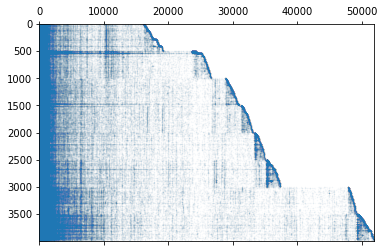

In [0]:
plt.spy(BX_train,markersize=0.01,aspect='auto')

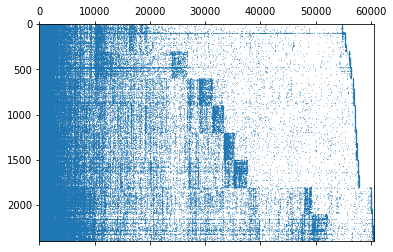

In [0]:
plt.spy(BX_test,markersize=0.1,aspect='auto')

In [0]:
def splitbyClass(csr):
    csr1 = csr[:1000,:]
    csr2 = csr[1000:2000,:]
    csr3 = csr[2000:3000,:]
    csr4 = csr[-1000:,:]
    return([csr1,csr2,csr3,csr4])

In [0]:
s = splitbyClass(BX_train)
freqmatrix = splitbyClass(X_train)

In [0]:
def multi(matrix):
    c=[]
    ix=[]
    for i in range(matrix.shape[0]):
        idx = matrix.getrow(i).nonzero()[1]
        x = matrix[i,idx].toarray()
        c.append(np.prod(x))
    return(np.array(c))

In [0]:
#MLE using each conditional probability
def NBC(csr,test): #No Laplace Smoothing
    addition=[]
    for i in range(4):
        addition.append(csr[i].sum(axis=0))
    
    if addition[0].shape[1]<test.shape[1]:
        for i in range(4):
            addition[i]=np.hstack((addition[i],
                                   np.zeros((1,test.shape[1]-addition[i].shape[1]))))      

    cond=[]
    for i in range(4):
      cond.append(test.multiply(addition[i]/1000).tocsr())

    return(np.vstack((multi(cond[0]),multi(cond[1]),multi(cond[2]),multi(cond[3]))))

In [0]:
q2b = np.diagonal(metrics.confusion_matrix(Y_train,np.argmax(NBC(s,BX_train),axis=0))/10) #Q2-b  # Training Accuracy

In [0]:
#Q2-c
#MLE using each conditional probability 
def LNBC(csr,test): #With Laplace Smoothing
    addition=[]
    for i in range(4):
        addition.append(csr[i].sum(axis=0))
    
    if addition[0].shape[1]<test.shape[1]:
        for i in range(4):
            addition[i]=np.hstack((addition[i],
                                   np.zeros((1,test.shape[1]-addition[i].shape[1]))))     

    cond=[]
    for i in range(4):
        cond.append(test.multiply(np.log((addition[i]+1)/(1002))).tocsr())

    return(np.hstack([cond[0].sum(axis=1),
                      cond[1].sum(axis=1),
                      cond[2].sum(axis=1),
                      cond[3].sum(axis=1)]))

In [0]:
q2c = metrics.confusion_matrix(Y_train,np.argmax(LNBC(s,BX_train),axis=1)) #Q2-c # Training Accuracy

In [0]:
q2cacc = np.diagonal(metrics.confusion_matrix(Y_train,np.argmax(LNBC(s,BX_train),axis=1))/10) #Q2-c # Training Accuracy

In [0]:
testacc = metrics.confusion_matrix(Y_test,np.argmax(LNBC(s,BX_test),axis=1)) #Q2-c # Test Accuracy

In [0]:
#Q2-d
#MLE using each conditional probability
def MNBC(csr,test): #Multinomial with Laplace smoothing
    addition=[]
    for i in range(4):
        addition.append(csr[i].sum(axis=0))
    
    if addition[0].shape[1]<test.shape[1]:
        for i in range(4):
            addition[i]=np.hstack((addition[i],
                                   np.zeros((1,test.shape[1]-addition[i].shape[1]))))
            
    cond=[]
    for i in range(4):
        cond.append(test.multiply(
            np.log(
                addition[i]+1/(addition[i].sum(axis=1)+51949))).tocsr())
        
    return(np.hstack([cond[0].sum(axis=1),
                      cond[1].sum(axis=1),
                      cond[2].sum(axis=1),
                      cond[3].sum(axis=1)]))

In [0]:
metrics.confusion_matrix(Y_test,np.argmax(MNBC(freqmatrix,X_test),axis=1))/6 #Q2-d # Test Accuracy

array([[87.66666667,  0.33333333,  1.33333333, 10.66666667],
       [ 0.5       , 82.66666667,  0.        , 16.83333333],
       [ 0.83333333,  0.16666667, 91.        ,  8.        ],
       [ 0.33333333,  0.66666667,  0.33333333, 98.66666667]])